In [1]:

import sklearn.datasets as datasets
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.ticker as mticker
from matplotlib.pylab import rcParams
import pickle
import pydotplus
from sklearn.tree import export_graphviz
from six import StringIO
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import accuracy_score,recall_score
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from numpy import loadtxt
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import shap

shap.initjs()



data = pd.read_csv(
    'log01HEBING3foldnafillmedian2.csv',
)

print(len(data))
data.head()

311


PRE  PHYLO  Diet-Inv  Diet-VectEXCFISH  Diet-Vfish  Diet-Fruit  Diet-Nect  \
0  1.0    4.0       0.7               0.3         0.0         0.0        0.0   
1  1.0    1.0       1.0               0.0         0.0         0.0        0.0   
2  1.0    1.0       0.8               0.0         0.0         0.2        0.0   
3  1.0    1.0       1.0               0.0         0.0         0.0        0.0   
4  1.0    1.0       0.4               0.0         0.0         0.3        0.0   

   Diet-Seed  Diet-PlantO  ForStrat-ground  ...  mig_partialmigrant  \
0        0.0          0.0              0.3  ...                   0   
1        0.0          0.0              0.6  ...                   0   
2        0.0          0.0              0.5  ...                   1   
3        0.0          0.0              0.0  ...                   0   
4        0.3          0.0              0.7  ...                   1   

   mig_resident  Tarsus.Length  Wing.Length  Beak.Length_Culmen  Tail.Length  \
0             1           1.55         2.30                1.40         2.07   
1             1           1.46         1.85                1.24         1.67   
2             0           1.48         1.95                1.30         1.84   
3             1           1.39         1.84                1.30         1.76   
4             0           1.35         1.83                1.16         1.83   

   Threatened  pop.decreasing  pop.stable  pop.increasing  
0           0               0           1               0  
1           0               0           1               0  
2           0               0           1               0  
3           0               0           1               0  
4           0               1           0               0  

[5 rows x 29 columns]

In [2]:
#Drop “Tail Length” from the list of features
target = data[['PRE']]
features = data.drop('PRE', axis=1) 
features = features.drop('Tail.Length', axis=1)
features = features.drop('Wing.Length', axis=1)
features.head()

PHYLO  Diet-Inv  Diet-VectEXCFISH  Diet-Vfish  Diet-Fruit  Diet-Nect  \
0    4.0       0.7               0.3         0.0         0.0        0.0   
1    1.0       1.0               0.0         0.0         0.0        0.0   
2    1.0       0.8               0.0         0.0         0.2        0.0   
3    1.0       1.0               0.0         0.0         0.0        0.0   
4    1.0       0.4               0.0         0.0         0.3        0.0   

   Diet-Seed  Diet-PlantO  ForStrat-ground  ForStrat-understory  ...  Mig.dis  \
0        0.0          0.0              0.3                  0.2  ...     0.00   
1        0.0          0.0              0.6                  0.4  ...     0.00   
2        0.0          0.0              0.5                  0.5  ...     3.26   
3        0.0          0.0              0.0                  0.3  ...     0.00   
4        0.3          0.0              0.7                  0.3  ...     3.13   

   mig_strictmig  mig_partialmigrant  mig_resident  Tarsus.Length  \
0              0                   0             1           1.55   
1              0                   0             1           1.46   
2              0                   1             0           1.48   
3              0                   0             1           1.39   
4              0                   1             0           1.35   

   Beak.Length_Culmen  Threatened  pop.decreasing  pop.stable  pop.increasing  
0                1.40           0               0           1               0  
1                1.24           0               0           1               0  
2                1.30           0               0           1               0  
3                1.30           0               0           1               0  
4                1.16           0               1           0               0  

[5 rows x 26 columns]

In [42]:

x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=0)
x_train["PHYLO"].astype("category")
x_train.shape
x_train.ndim
print(features)

     PHYLO  Diet-Inv  Diet-VectEXCFISH  Diet-Vfish  Diet-Fruit  Diet-Nect  \
0      4.0       0.7               0.3         0.0         0.0        0.0   
1      1.0       1.0               0.0         0.0         0.0        0.0   
2      1.0       0.8               0.0         0.0         0.2        0.0   
3      1.0       1.0               0.0         0.0         0.0        0.0   
4      1.0       0.4               0.0         0.0         0.3        0.0   
..     ...       ...               ...         ...         ...        ...   
306    1.0       0.8               0.0         0.0         0.1        0.1   
307    1.0       1.0               0.0         0.0         0.0        0.0   
308    1.0       0.8               0.2         0.0         0.0        0.0   
309   10.0       0.0               0.0         0.0         0.0        0.0   
310    1.0       0.4               0.0         0.0         0.3        0.0   

     Diet-Seed  Diet-PlantO  ForStrat-ground  ForStrat-understory  ...  \
0

In [5]:
model=xgb.XGBClassifier(
    max_depth=3,
    n_estimators=500,
    learning_rate=0.1,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=0,
    scale_pos_weight=2,
    objective = "binary:logistic",
    )

model.fit(x_train,y_train)




[14:45:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=40, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=0,
              scale_pos_weight=2, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [14]:
# def objective(trial):
#     param = {
#         'max_depth': trial.suggest_int('max_depth', 3,10),
#         'lambda': trial.suggest_uniform('lambda', 0, 10.0),
#         'alpha': trial.suggest_uniform('alpha', 0, 10),
#         'min_child_weight': trial.suggest_int('min_child_weight', 0, 5),
#         'gamma': trial.suggest_uniform('gamma', 0, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate',0.01,0.5),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.2, 0.9),
#         'subsample': trial.suggest_uniform('subsample', 0.2, 0.9),
#         #'n_estimators': 4000,
#         'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 2),
#         'nthread': -1
#     }
#     model = xgb.XGBClassifier(**param)
#     model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=20, verbose=False)
#     preds = model.predict(x_test)
#     auc = accuracy_score(y_test, preds)
#     return auc


In [43]:
from sklearn.metrics import mean_squared_error
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3,10),
        'lambda': trial.suggest_uniform('lambda', 0, 7),
        'alpha': trial.suggest_uniform('alpha', 0, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 5),
        'gamma': trial.suggest_uniform('gamma', 0, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate',0.01,0.4),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.2, 0.9),
        'subsample': trial.suggest_uniform('subsample', 0.2, 0.9),
        'n_estimators': trial.suggest_int('n_estimators', 3000,7000),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 2),
        'nthread': -1
    }
    model = xgb.XGBClassifier(**param)
    model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=20, verbose=False)
    preds = model.predict(x_test)
    #recall = recall_score(y_test, preds, squared=False)
    #return recall
    auc = accuracy_score(y_test, preds)
    return auc


In [44]:
import sys
from optuna.samplers import TPESampler
# file = open('output0120.txt','w')
# sys.stdout = file
study1 = optuna.create_study(direction='maximize',sampler = TPESampler())
n_trials=1000
study1.optimize(objective, n_trials=n_trials, show_progress_bar = True)
print('Number of finished trials:', len(study1.trials))
print("------------------------------------------------")
print('Best trial:', study1.best_trial.params)
print("------------------------------------------------")
print(study1.trials_dataframe())
print("------------------------------------------------")
# file.close()
# sys.stdout = sys.__stdout__


[I 2024-01-22 01:52:23,137] A new study created in memory with name: no-name-fb802446-1ede-4801-bc5f-5727f9fc0e73
/ceph-data/zy/software/anaconda3/envs/pyt/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/1000 [00:00<?, ?it/s]

[01:52:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[I 2024-01-22 01:52:26,908] Trial 0 finished with value: 0.7777777777777778 and parameters: {'max_depth': 3, 'lambda': 1.0131232825693544, 'alpha': 0.525479455060865, 'min_child_weight': 2, 'gamma': 0.8197968893110674, 'learning_rate': 0.19228275751660548, 'colsample_bytree': 0.6322974644632096, 'subsample': 0.7977536690837215, 'n_estimators': 3501, 'scale_pos_weight': 1.3353775316974679}. Best is trial 0 with value: 0.7777777777777778.
[01:52:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[I 2024-01-22 01:52:27,555] Trial 1 finished with value

In [46]:
optuna.visualization.plot_optimization_history(study1)

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1078, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/ceph-data/zy/software/anaconda3/envs/pyt/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/ceph-data/zy/software/anaconda3/envs/pyt/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

In [16]:
optuna.visualization.plot_slice(study1)

In [47]:
#Best trial: {'lambda': 0.19696603310621064, 'alpha': 1.3223611283785455, 'colsample_bytree': 0.5, 
#'subsample': 0.6, 'learning_rate': 0.3092644741103405, 'gamma': 0.7778860635860129, 'max_depth': 6,
#'min_child_weight': 3, 'scale_pos_weight': 1.2}
params_4=study1.best_params
params_4
# trial = study1.best_trial
# trial.value



{'max_depth': 6,
 'lambda': 0.8379268419867857,
 'alpha': 0.43237307914250733,
 'min_child_weight': 5,
 'gamma': 1.0227180316146436,
 'learning_rate': 0.34664031905450715,
 'colsample_bytree': 0.5235475904401844,
 'subsample': 0.6935230941362818,
 'n_estimators': 3456,
 'scale_pos_weight': 1.0784931624791891}

In [17]:
#Tuning again with more narrower values to get the sweet spot

def objective(trial):
    param = {
        'max_depth': trial.suggest_categorical('max_depth', [8,10]),
        'lambda': trial.suggest_uniform('lambda', 2, 3.8),
        'alpha': trial.suggest_uniform('alpha', 0, 2),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1]),
        'gamma': trial.suggest_uniform('gamma', 0, 2),
        'learning_rate': trial.suggest_loguniform('learning_rate',0.2,0.4),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.8, 0.9),
        'subsample': trial.suggest_uniform('subsample', 0.4, 0.63),
        #'n_estimators': 4000,
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 1.4),
        'nthread': -1
    }
    model = xgb.XGBClassifier(**param,eval_metric="logloss")
    model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=20, verbose=False)
    preds = model.predict(x_test)
    auc = accuracy_score(y_test, preds)
    return auc



In [18]:
study2 = optuna.create_study(direction='maximize',sampler = TPESampler())
study2.optimize(objective, n_trials=550, show_progress_bar = True)

[I 2024-01-22 00:32:38,321] A new study created in memory with name: no-name-02a1a19e-99e0-4766-af44-8a050e7695e4
/ceph-data/zy/software/anaconda3/envs/pyt/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/550 [00:00<?, ?it/s]

[I 2024-01-22 00:32:40,387] Trial 0 finished with value: 0.6875 and parameters: {'max_depth': 8, 'lambda': 2.19294410663332, 'alpha': 1.195314428683859, 'min_child_weight': 1, 'gamma': 1.5975940499608967, 'learning_rate': 0.2535954463754993, 'colsample_bytree': 0.8555121732577897, 'subsample': 0.6013072438605305, 'scale_pos_weight': 1.2008339715719454}. Best is trial 0 with value: 0.6875.
[I 2024-01-22 00:32:42,562] Trial 1 finished with value: 0.78125 and parameters: {'max_depth': 10, 'lambda': 2.058088006191122, 'alpha': 1.7046076917884014, 'min_child_weight': 1, 'gamma': 1.7277856156858709, 'learning_rate': 0.3393268621769179, 'colsample_bytree': 0.8047696836624892, 'subsample': 0.4485481674088786, 'scale_pos_weight': 1.3876839917193768}. Best is trial 1 with value: 0.78125.
[I 2024-01-22 00:32:43,484] Trial 2 finished with value: 0.84375 and parameters: {'max_depth': 8, 'lambda': 3.3778629742311788, 'alpha': 0.8238077553165424, 'min_child_weight': 1, 'gamma': 1.9548225990956125, 'l

In [19]:
optuna.visualization.plot_optimization_history(study2)

In [20]:
optuna.visualization.plot_slice(study2)

In [23]:
params_3=study2.best_params
params_3

{'max_depth': 8,
 'lambda': 2.4512025762681002,
 'alpha': 0.08723852285707917,
 'min_child_weight': 1,
 'gamma': 0.3685356181265003,
 'learning_rate': 0.2824234522799908,
 'colsample_bytree': 0.8791491406016839,
 'subsample': 0.4965386289445581,
 'scale_pos_weight': 1.1540743996577996}

In [37]:
eval_set = [(x_train, y_train), (x_test, y_test)]
#final model
model=xgb.XGBClassifier(
    max_depth=6,
    #n_estimators=190,
    learning_rate=0.309,
    min_child_weight=3,
    subsample=0.6,
    colsample_bytree=0.5,
    gamma=0.78,
    reg_alpha=1.32,
    reg_lambda=0.197,
    scale_pos_weight=1.2,
    )

model.fit(x_train,y_train,eval_set=eval_set, verbose=True,early_stopping_rounds=20,eval_metric=["error", "logloss"])

[0]	validation_0-error:0.36201	validation_0-logloss:0.65546	validation_1-error:0.25000	validation_1-logloss:0.63820
[1]	validation_0-error:0.26882	validation_0-logloss:0.61346	validation_1-error:0.18750	validation_1-logloss:0.57798
[2]	validation_0-error:0.23656	validation_0-logloss:0.58925	validation_1-error:0.21875	validation_1-logloss:0.54743
[3]	validation_0-error:0.25806	validation_0-logloss:0.56291	validation_1-error:0.18750	validation_1-logloss:0.52021
[4]	validation_0-error:0.21147	validation_0-logloss:0.53643	validation_1-error:0.25000	validation_1-logloss:0.52812
[5]	validation_0-error:0.23297	validation_0-logloss:0.53501	validation_1-error:0.25000	validation_1-logloss:0.49390
[6]	validation_0-error:0.20430	validation_0-logloss:0.52157	validation_1-error:0.21875	validation_1-logloss:0.49685
[7]	validation_0-error:0.20788	validation_0-logloss:0.50303	validation_1-error:0.31250	validation_1-logloss:0.51445


[8]	validation_0-error:0.20430	validation_0-logloss:0.48693	validation_1-error:0.28125	validation_1-logloss:0.49308
[9]	validation_0-error:0.18996	validation_0-logloss:0.47790	validation_1-error:0.25000	validation_1-logloss:0.48154
[10]	validation_0-error:0.17921	validation_0-logloss:0.46017	validation_1-error:0.21875	validation_1-logloss:0.45637
[11]	validation_0-error:0.16846	validation_0-logloss:0.45040	validation_1-error:0.21875	validation_1-logloss:0.42885
[12]	validation_0-error:0.18280	validation_0-logloss:0.44380	validation_1-error:0.15625	validation_1-logloss:0.44173
[13]	validation_0-error:0.16129	validation_0-logloss:0.43966	validation_1-error:0.15625	validation_1-logloss:0.43878
[14]	validation_0-error:0.15771	validation_0-logloss:0.42947	validation_1-error:0.15625	validation_1-logloss:0.42423
[15]	validation_0-error:0.15412	validation_0-logloss:0.42216	validation_1-error:0.12500	validation_1-logloss:0.41071
[16]	validation_0-error:0.16129	validation_0-logloss:0.41423	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.78, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.309, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=40, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=1.32,
              reg_lambda=0.197, scale_pos_weight=1.2, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:

eval_set = [(x_train, y_train), (x_test, y_test)]
#final model
model=xgb.XGBClassifier(**params_4
    )

model.fit(x_train,y_train,eval_set=eval_set, verbose=True,early_stopping_rounds=30,eval_metric=["error", "logloss"])

[0]	validation_0-error:0.30645	validation_0-logloss:0.64020	validation_1-error:0.26984	validation_1-logloss:0.63372


[1]	validation_0-error:0.29032	validation_0-logloss:0.60494	validation_1-error:0.25397	validation_1-logloss:0.61480
[2]	validation_0-error:0.24597	validation_0-logloss:0.57176	validation_1-error:0.28571	validation_1-logloss:0.58056
[3]	validation_0-error:0.24597	validation_0-logloss:0.54892	validation_1-error:0.25397	validation_1-logloss:0.56700
[4]	validation_0-error:0.23790	validation_0-logloss:0.53598	validation_1-error:0.22222	validation_1-logloss:0.56287
[5]	validation_0-error:0.21774	validation_0-logloss:0.52404	validation_1-error:0.28571	validation_1-logloss:0.55469
[6]	validation_0-error:0.21371	validation_0-logloss:0.51608	validation_1-error:0.26984	validation_1-logloss:0.54867
[7]	validation_0-error:0.22177	validation_0-logloss:0.50561	validation_1-error:0.19048	validation_1-logloss:0.52720
[8]	validation_0-error:0.20968	validation_0-logloss:0.49687	validation_1-error:0.20635	validation_1-logloss:0.51491
[9]	validation_0-error:0.20564	validation_0-logloss:0.48703	validation_1

XGBClassifier(alpha=0.43237307914250733, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5235475904401844, enable_categorical=False,
              gamma=1.0227180316146436, gpu_id=-1, importance_type=None,
              interaction_constraints='', lambda=0.8379268419867857,
              learning_rate=0.34664031905450715, max_delta_step=0, max_depth=6,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=3456, n_jobs=40, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.432373077,
              reg_lambda=0.837926865, scale_pos_weight=1.0784931624791891,
              subsample=0.6935230941362818, tree_method='exact',
              validate_parameters=1, verbosity=None)

{'validation_0': OrderedDict([('error', [0.306452, 0.290323, 0.245968, 0.245968, 0.237903, 0.217742, 0.21371, 0.221774, 0.209677, 0.205645, 0.197581, 0.205645, 0.197581, 0.197581, 0.181452, 0.169355, 0.149194, 0.16129, 0.181452, 0.169355, 0.157258, 0.165323, 0.157258, 0.169355, 0.137097, 0.153226, 0.145161, 0.145161, 0.149194, 0.145161, 0.137097, 0.137097, 0.120968, 0.133065, 0.116935, 0.125, 0.120968, 0.112903, 0.112903, 0.116935, 0.116935, 0.120968, 0.112903, 0.104839, 0.108871, 0.104839, 0.100806, 0.096774, 0.096774, 0.096774, 0.100806, 0.100806, 0.096774, 0.08871]), ('logloss', [0.640202, 0.60494, 0.571757, 0.548915, 0.535983, 0.524045, 0.51608, 0.505606, 0.49687, 0.487031, 0.472225, 0.463888, 0.459985, 0.452246, 0.448692, 0.44523, 0.436038, 0.427625, 0.421528, 0.417808, 0.413107, 0.411174, 0.408774, 0.408874, 0.403585, 0.39998, 0.395866, 0.392824, 0.392649, 0.391519, 0.390462, 0.385433, 0.380724, 0.376881, 0.376131, 0.373685, 0.368834, 0.367837, 0.367826, 0.365225, 0.360314, 0.357

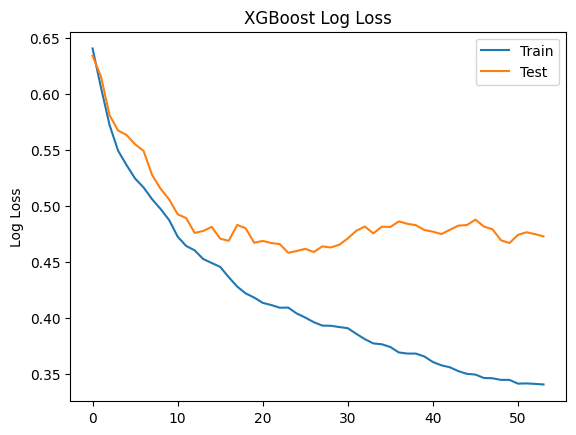

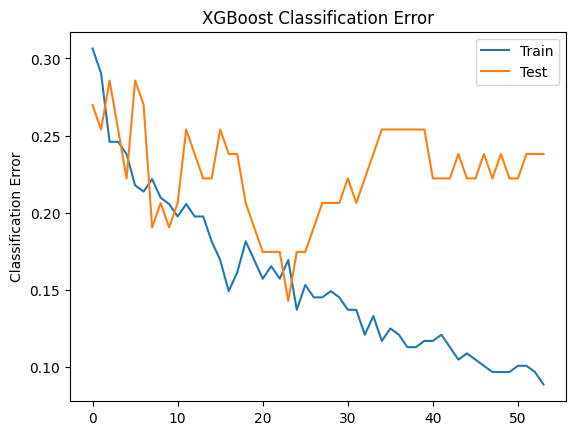

In [52]:
from matplotlib import pyplot

results = model.evals_result()
print(results)
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

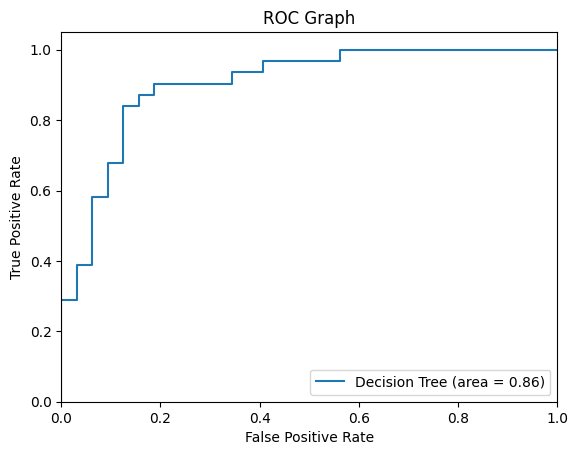

决策树 AUC = 0.86
0.8571428571428571
              precision    recall  f1-score   support

         0.0       0.90      0.81      0.85        32
         1.0       0.82      0.90      0.86        31

    accuracy                           0.86        63
   macro avg       0.86      0.86      0.86        63
weighted avg       0.86      0.86      0.86        63



In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
clf_roc_auc = roc_auc_score(y_test, model.predict(x_test))
clf_fpr, clf_tpr, clf_thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(clf_fpr, clf_tpr, label='Decision Tree (area = %0.2f)' % clf_roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()
print ("决策树 AUC = %2.2f" % clf_roc_auc)
Y_pred = model.predict(x_test)
print(accuracy_score(y_test, Y_pred))
print(classification_report(y_test, Y_pred))

In [55]:
from sklearn.model_selection import cross_val_score,KFold


score = model.score(x_train, y_train) 
print("Training score: ", score)

scores = cross_val_score(model, x_train, y_train,cv=5)
print(np.mean(scores), np.std(scores))
print(scores)
print(classification_report(y_test, Y_pred))
print("Mean cross-validation score: %.2f" % scores.mean())

# kfold = KFold(n_splits=10, shuffle=True)
# kf_cv_scores = cross_val_score(model, x_train, y_train, cv=kfold )
# print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Training score:  0.8306451612903226
[02:39:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:39:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:39:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:40:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, recall_score

# 定义评分函数：召回率
scorer = make_scorer(recall_score)

# 使用cross_val_score进行交叉验证，指定scoring参数为自定义的评分函数
scores = cross_val_score(model, x_train, y_train, cv=10, scoring=scorer)
print(scores)
print("Mean cross-validation score (Recall): %.2f" % scores.mean())


[01:11:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

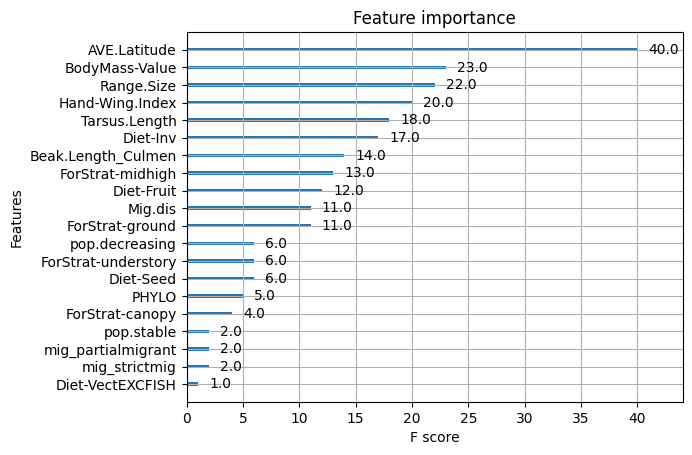

0.90625
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89        15
         1.0       0.85      1.00      0.92        17

    accuracy                           0.91        32
   macro avg       0.93      0.90      0.90        32
weighted avg       0.92      0.91      0.90        32



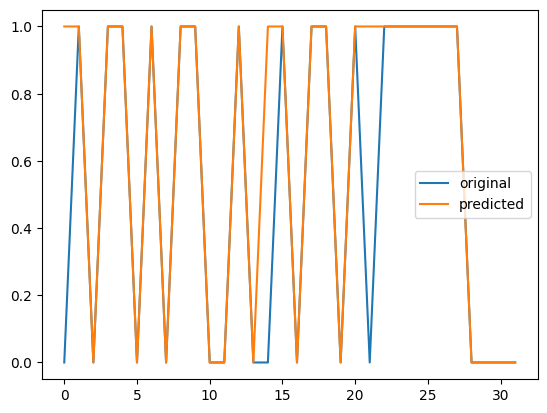

In [43]:
from sklearn.metrics import mean_squared_error
plot_importance(model)
plt.show()


x_ax = range(len(y_test))

Y_pred = model.predict(x_test)
print(accuracy_score(y_test, Y_pred))
print(classification_report(y_test, Y_pred))

plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, Y_pred, label="predicted")
#plt.title("Boston test and predicted data")
plt.legend()
plt.show()

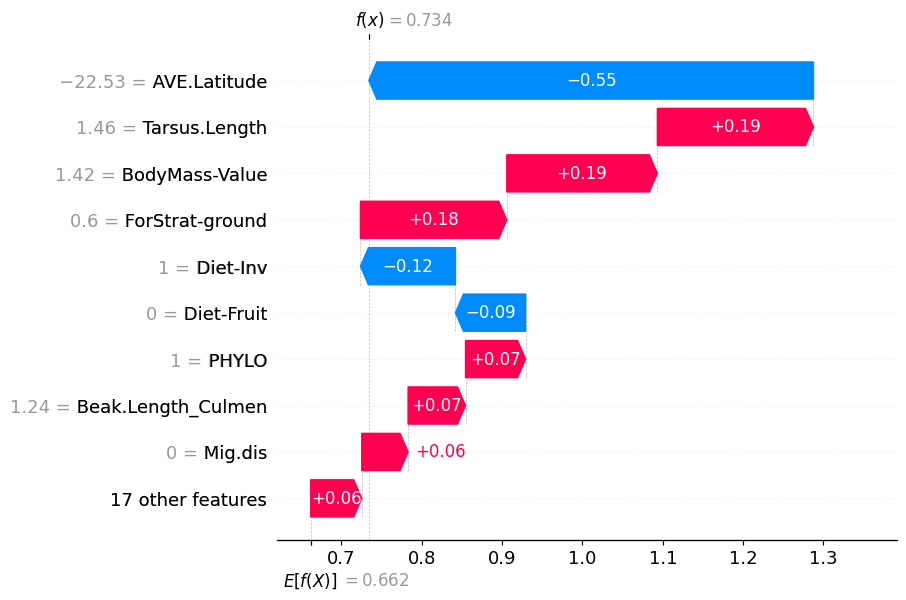

In [84]:
# get shap values
explainer = shap.Explainer(model)
shap_values = explainer(features)
np.shape(shap_values.values)
# shap_values = explainer(X[0:100])
# waterfall plot for first observation
shap.plots.waterfall(shap_values[1])

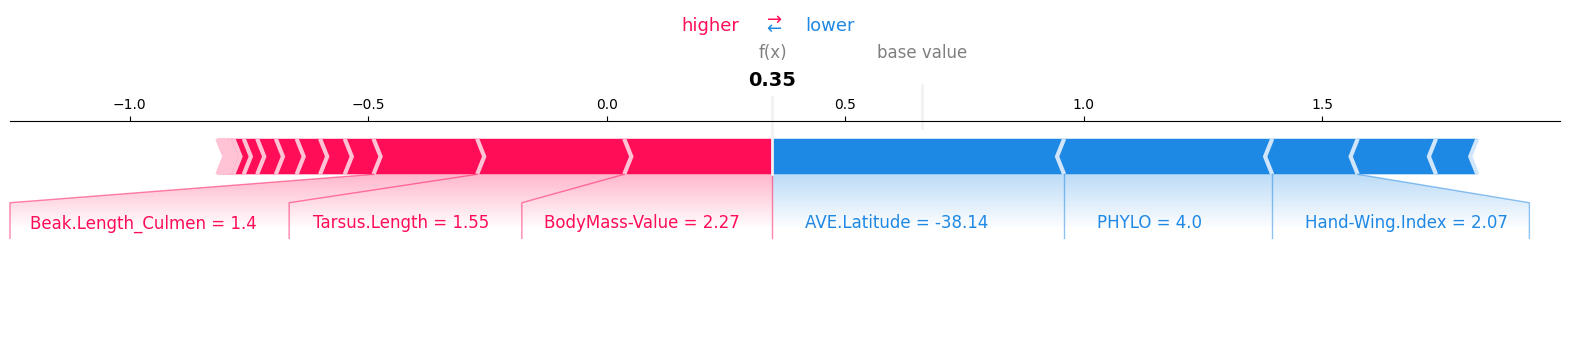

In [96]:
# force plot
shap.plots.force(shap_values[0], matplotlib=True)
# stacked force plot
shap.plots.force(shap_values[0:311])

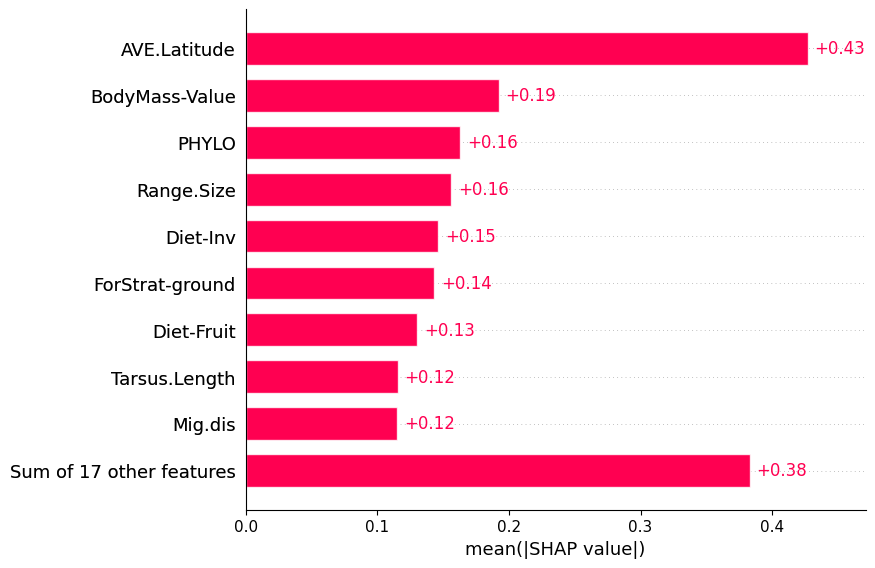

In [97]:
# mean SHAP
shap.plots.bar(shap_values)

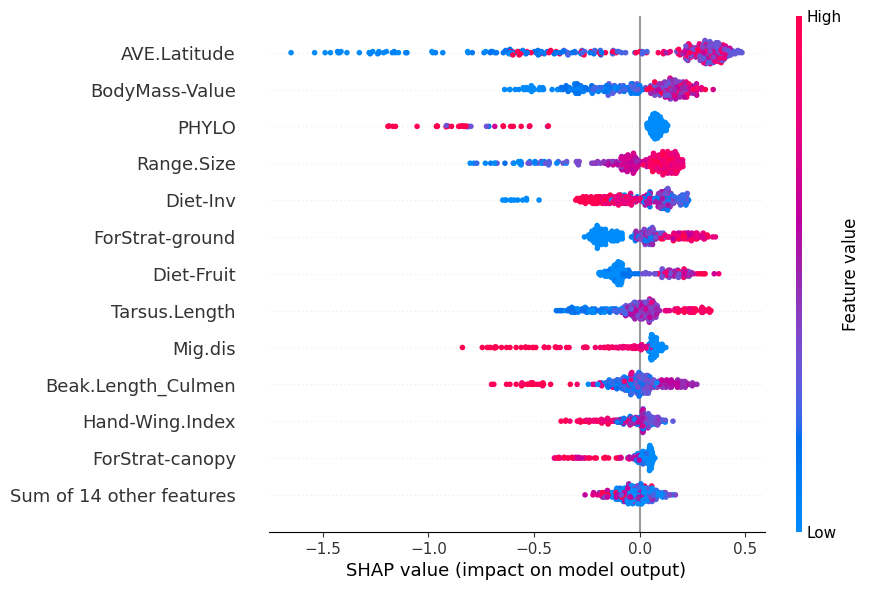

In [106]:
# beeswarm plot
shap.plots.beeswarm(shap_values,max_display=13)

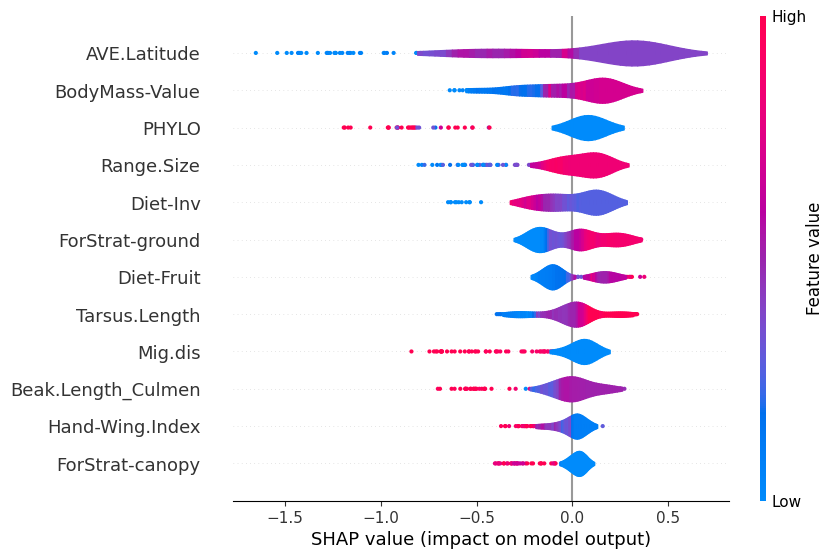

In [105]:
# violin plot
shap.plots.violin(shap_values,max_display=12)

not enough data in bin #5 for feature Diet-Nect, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #7 for feature Diet-Nect, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #4 for feature Diet-VectEXCFISH, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #5 for feature Diet-VectEXCFISH, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #9 for feature Diet-Seed, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #11 for feature ForStrat-understory, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #9 for feature ForStrat-canopy, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #12 for feature ForStrat-canopy, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #9 for feat

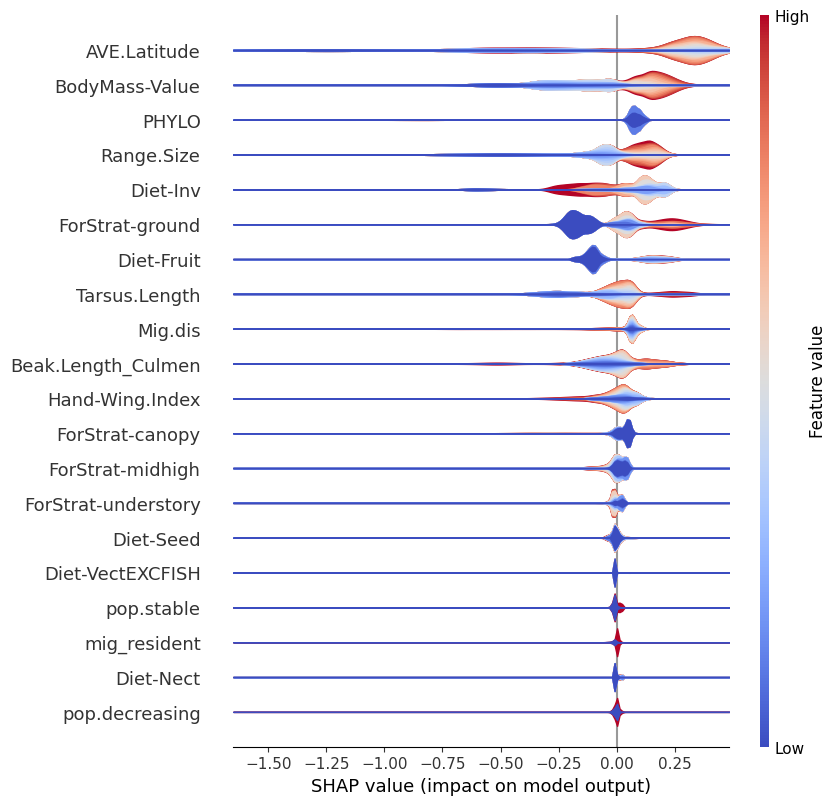

In [107]:
# layered violin plot
shap.plots.violin(shap_values, plot_type="layered_violin")

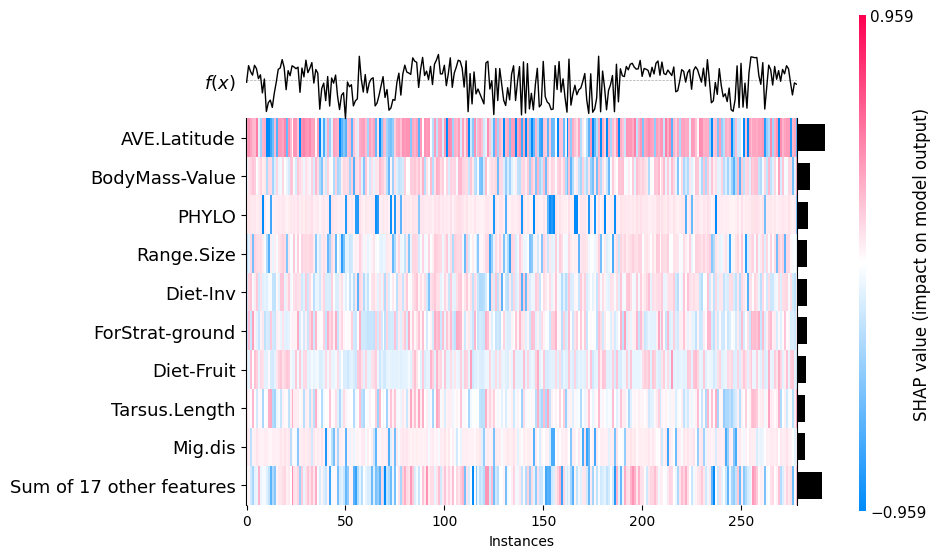

In [114]:
# order by predictions
y_pred = model.predict(x_train)
order = np.argsort(y_pred)
shap.plots.heatmap(shap_values, instance_order=order)
# order by shell weight value
# order = np.argsort(data["BodyMass-Value"])
# shap.plots.heatmap(shap_values, instance_order=order)

In [97]:
preictdata = pd.read_csv('y_pred0110.csv')


x_pre = preictdata.drop(['PRE', 'species','Wing.Length','Tail.Length'],axis=1) 
x_pre
x_predicted = model.predict(x_pre)

pd_data = pd.DataFrame(x_predicted)
pd_data.to_csv('out0117.csv', index=None)

In [11]:
x_predicted=model.predict(x_test)
x_predicted

pd_data = pd.DataFrame(x_predicted)
pd_data.to_csv('out.csv', index=None)
pd_data2 = pd.DataFrame(y_test)
pd_data2.to_csv('out2.csv', index=None)




({'mean_fit_time': array([6.36382079, 5.74522076, 5.39662275, 4.99956374, 6.94108763,
         6.52795477, 6.10969315, 5.62538533, 7.07062945, 6.68603129,
         6.41132593, 5.8090333 , 8.00758324, 7.52649093, 6.95687451,
         6.44625001]),
  'std_fit_time': array([0.32611892, 0.05455868, 0.07484578, 0.05976207, 0.02364322,
         0.05315742, 0.03726514, 0.05629667, 0.0625728 , 0.050419  ,
         0.11497527, 0.02111071, 0.02276874, 0.03371776, 0.0497392 ,
         0.04541408]),
  'mean_score_time': array([0.04536352, 0.04300804, 0.04691701, 0.0425899 , 0.0434361 ,
         0.04362168, 0.043401  , 0.040768  , 0.03859339, 0.04483676,
         0.04318275, 0.04271221, 0.04374328, 0.04370532, 0.04366336,
         0.04163103]),
  'std_score_time': array([0.00468835, 0.00459158, 0.0048675 , 0.0012999 , 0.00357063,
         0.00242326, 0.00255511, 0.00435937, 0.0050998 , 0.00224535,
         0.00173983, 0.00218493, 0.00116283, 0.00095982, 0.00093627,
         0.00205622]),
  'param_c

(30097, 21)
19


/ceph-data/zy/software/anaconda3/envs/pyt/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 Model Report
Accuracy : 0.8621
AUC Score (Train): 0.862554
[0.04391737 0.05057416 0.03462609 0.03784269 0.04085813 0.04393663
 0.04156828 0.04468415 0.05693814 0.04061981 0.05999982 0.04089153
 0.0597442  0.05268319 0.03911936 0.04914564 0.05728119 0.11935313
 0.08621644]


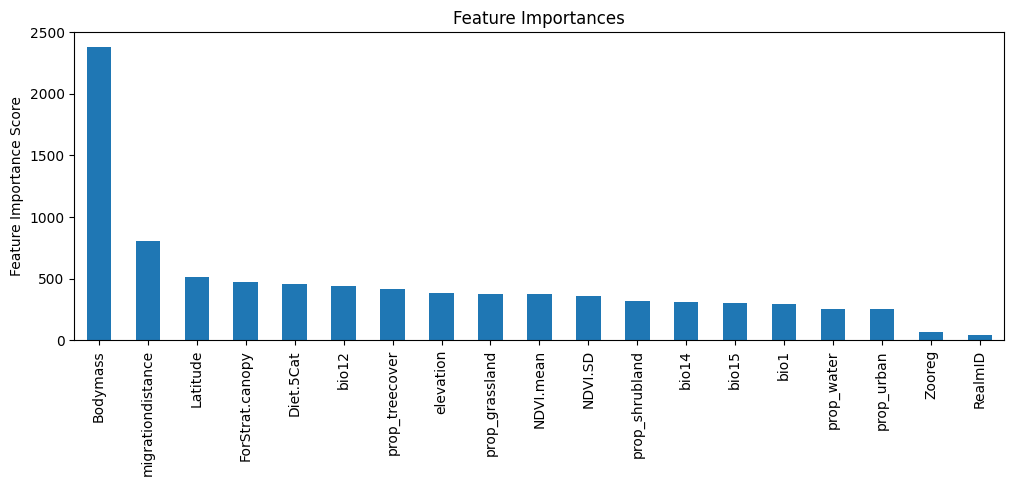

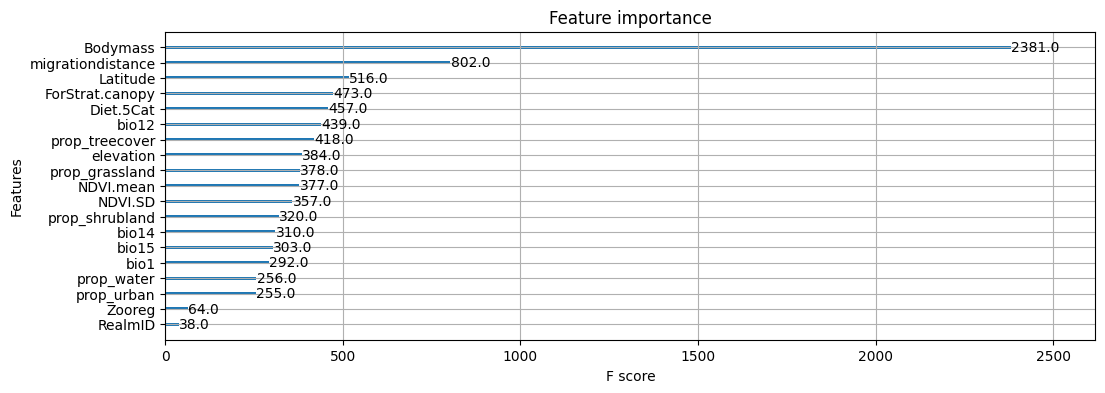

In [23]:
xgb1 = XGBClassifier(
learning_rate =0.1,
n_estimators=1000,
max_depth=6,
min_child_weight=1,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
objective= 'binary:logistic',
nthread=4,
scale_pos_weight=1,
seed=27
)
#xgb1.fit(X_train, Y_train)
#定义的那个函数 train=data




print(train.shape)
print(len(predictors))

modelfit(xgb1,train,predictors)

# 打印模型特征重要程度并画图显示
print(xgb1.feature_importances_)
plot_importance(xgb1)
plt.show()

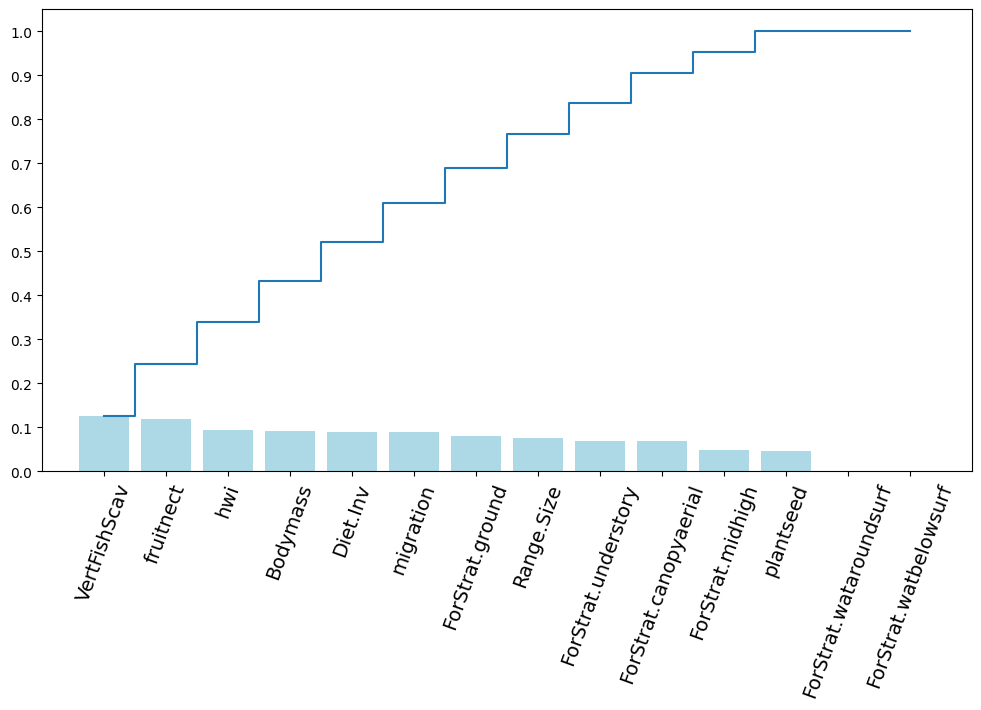

In [18]:
    f_importance = xgb1.feature_importances_
    #画权重图
    featurename = ["Bodymass","ForStrat.watbelowsurf","ForStrat.wataroundsurf","ForStrat.ground","ForStrat.understory","ForStrat.midhigh","ForStrat.canopyaerial","Diet.Inv","fruitnect","plantseed","VertFishScav","hwi","migration","Range.Size"]
    featurename = np.array(featurename)
    indices = np.argsort(f_importance)[::-1]
    plt.figure(figsize=(12,6))
    #plt.title("Feature importances by Decision Tree")
    plt.bar(range(len(indices)), f_importance[indices], color='lightblue',  align="center")
    plt.step(range(len(indices)), np.cumsum(f_importance[indices]), where='mid', label='Cumulative')
    plt.xticks(range(len(indices)), featurename[indices], rotation=70,fontsize=14)
    plt.xlim([-1, len(indices)])    
    y_major_locator= MultipleLocator(0.1)
    ax=plt.gca()
    ax.yaxis.set_major_locator(y_major_locator)
    plt.show()

    #print('Accuracy on training set: {:.3f}'.format(xgb1.score(X_train, Y_train)))
    #print('Accuracy on test set: {:.3f}'.format(mxgb1.score(X_test, Y_test)))


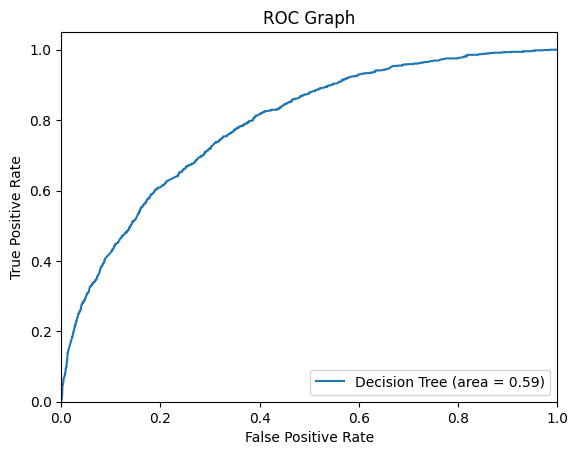

决策树 AUC = 0.59
0.8542192691029901
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92      6352
         1.0       0.59      0.20      0.30      1173

    accuracy                           0.85      7525
   macro avg       0.73      0.59      0.61      7525
weighted avg       0.83      0.85      0.82      7525



In [31]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
clf_roc_auc = roc_auc_score(Y_test, gbcf.predict(X_test))
clf_fpr, clf_tpr, clf_thresholds = roc_curve(Y_test, gbcf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(clf_fpr, clf_tpr, label='Decision Tree (area = %0.2f)' % clf_roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()
print ("决策树 AUC = %2.2f" % clf_roc_auc)
Y_pred = gbcf.predict(X_test)
print(accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

In [ ]:
 mae = []
    range_st = 9
    range_ed = 10
    range_step = 1
    for depth in range(range_st, range_ed, range_step):
        print('Depth = {}'.format(depth))
        model = DecisionTreeClassifier(splitter='best', max_depth=depth, random_state = 1)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
            # print(Y_test[0:10], Y_pred[0:10])
            # mae.append(accuracy_score(Y_test, Y_pred))
        print(accuracy_score(Y_test, Y_pred))
        print(classification_report(Y_test, Y_pred))
            # mse.append(metrics.mean_squared_error(Y_test, Y_pred))
        # print(mae)
        # print(mse)
        
    f_importance = model.feature_importances_
    y=[i for i in range(len(f_importance))]
    plt.figure(figsize = (6,3))
    plt.barh(y, np.array(f_importance), alpha=0.8,height = 0.3)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.show()

    dot_data = StringIO()
    featurename = ["migration distance","bodymass","ForStrat.canopy","Diet.5Cat","Latitude","bio1","bio12","bio14","bio15","elevation","prop_grassland","prop_water","prop_urban","prop_treecover","prop_shrubland","NDVI.mean","NDVI.SD","Zooreg","RealmID"]
    export_graphviz(model, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = featurename,class_names=['0','1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png('diabetesdelmodymass.png')
    #画权重图
    featurename = np.array(featurename)
    indices = np.argsort(f_importance)[::-1]
    plt.figure(figsize=(12,6))
    plt.title("Feature importances by Decision Tree")
    plt.bar(range(len(indices)), f_importance[indices], color='lightblue',  align="center")
    plt.step(range(len(indices)), np.cumsum(f_importance[indices]), where='mid', label='Cumulative')
    plt.xticks(range(len(indices)), featurename[indices], rotation=70,fontsize=14)
    plt.xlim([-1, len(indices)])    
    y_major_locator= MultipleLocator(0.1)
    ax=plt.gca()
    ax.yaxis.set_major_locator(y_major_locator)
    plt.show()
    

In [ ]:

dot_data = StringIO()
featurename = ["Bodymass","ForStrat.canopy","Diet.5Cat","Latitude","bio1","bio12","bio14","bio15","elevation","prop_grassland","prop_water","prop_urban","prop_treecover","prop_shrubland","NDVI.mean","NDVI.SD","Zooreg","RealmID"]
export_graphviz(model, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = featurename,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('diabetes.png')

In [ ]:

featurename = ["Bodymass","ForStrat.canopy","Diet.5Cat","Latitude","bio1","bio12","bio14","bio15","elevation","prop_grassland","prop_water","prop_urban","prop_treecover","prop_shrubland","NDVI.mean","NDVI.SD","Zooreg","RealmID"]
featurename = np.array(featurename)
indices = np.argsort(f_importance)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by Decision Tree")
plt.bar(range(len(indices)), f_importance[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(f_importance[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), featurename[indices], rotation=70,fontsize=14)
plt.xlim([-1, len(indices)])
y_major_locator= MultipleLocator(0.1)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
plt.show()